本章学习线性回归、局部加权线性回归和收缩方法。回归是前面所有章节的监督方法的延续。

监督学习指的是有目标变量或预测目标的机器学习方法。回归与分类的不同，就在于其目标变量是连续数值型。

本章首先介绍线性回归，之后引入了局部平滑技术，分析如何更好地拟合数据。之后学习回归在“欠拟合”情况下的缩减（shrinkage）技术，探讨偏差和方差的概念。

## 8.1 用线性回归找到最佳拟合直线

$$
y=x^Tw
$$



> 优点：结果易于理解，计算上不复杂。
>
> 缺点：对非线性的数据拟合不好。
>
> 适用数据类型：数值型和标称型数据。

回归，一般都是指线性回归（linear regression），所以本章里的回归和线性回归代表同一个意思。线性回归意味着可以将输入项分别乘以一些常量，再将结果加起来得到输出。

> 今天我们所知道的回归是由达尔文（Charles Darwin）的表兄弟Francis Galton发明的。他注意到，如果双亲的高度比平均高度高，他们的子女也倾向于比平均高度高，但尚不及双亲。孩子的高度向着平均高度回退（回归）。Galton在多项研究上都注意到这个现象，所以尽管这个英文单词跟数值预测没有任何关系，但这种研究方法仍被称作回归。

为了找到$w$，一般的做法是：找出使平方误差最小的$w$：
$$
\sum_{i=1}^m(y_i-x_i^Tw)^2
$$
对$w$求导$X^T(Y-Xw)$，令导数等于0，解出 :
$$
\hat{w} ={(X^TX)}^{-1}X^Ty
$$
${(X^TX)}^{-1}$​需要对矩阵求逆，因此这个方程只在逆矩阵存在的时候适用。

最佳w求解是统计学中的常见问题，除了矩阵方法外还有很多其他方法可以解决。通过调用NumPy库里的矩阵方法，我们可以仅使用几行代码就完成所需功能。

下面的代码，是一段我们待回归的数据，的准备工作。

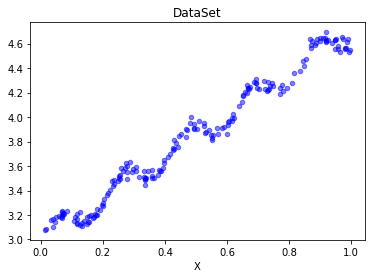

In [1]:
# -*- coding:utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np

def loadDataSet(fileName):
    """
    函数说明:加载数据
    Parameters:
        fileName - 文件名
    Returns:
        xArr - x数据集
        yArr - y数据集
    """

    numFeat = len(open(fileName).readline().split('\t')) - 1
    xArr = []; yArr = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        xArr.append(lineArr)
        yArr.append(float(curLine[-1]))
    return xArr, yArr

def plotDataSet():
    """
    函数说明:绘制数据集
    Parameters:
        无
    Returns:
        无
    """
    xArr, yArr = loadDataSet('data/Ch08/ex0.txt')                                    #加载数据集
    n = len(xArr)                                                        #数据个数
    xcord = []; ycord = []                                                #样本点
    for i in range(n):                                                   
        xcord.append(xArr[i][1]); ycord.append(yArr[i])                    #样本点
    fig = plt.figure()
    ax = fig.add_subplot(111)                                            #添加subplot
    ax.scatter(xcord, ycord, s = 20, c = 'blue',alpha = .5)                #绘制样本点
    plt.title('DataSet')                                                #绘制title
    plt.xlabel('X')
    plt.show()

plotDataSet()

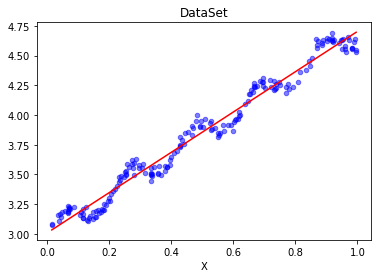

In [3]:
def standRegres(xArr,yArr):
    """
    函数说明:计算回归系数w
    Parameters:
        xArr - x数据集
        yArr - y数据集
    Returns:
        ws - 回归系数
    """
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    xTx = xMat.T * xMat                            #根据文中推导的公示计算回归系数
    if np.linalg.det(xTx) == 0.0:
        print("矩阵为奇异矩阵,不能求逆")
        return
    # 上面的推倒公式
    ws = xTx.I * (xMat.T*yMat)
    return ws

def main():
    xArr, yArr = loadDataSet('data/Ch08/ex0.txt')
    ws = standRegres(xArr, yArr)                                        #计算回归系数
    xMat = np.mat(xArr)                                                    #创建xMat矩阵
    yMat = np.mat(yArr)                                                    #创建yMat矩阵
    xCopy = xMat.copy()                                                    #深拷贝xMat矩阵
    xCopy.sort(0)                                                        #排序
    yHat = xCopy * ws                                                     #计算对应的y值
    fig = plt.figure()
    ax = fig.add_subplot(111)                                            #添加subplot
    ax.plot(xCopy[:, 1], yHat, c = 'red')                                #绘制回归曲线
    ax.scatter(xMat[:,1].flatten().A[0], yMat.flatten().A[0], s = 20, c = 'blue',alpha = .5)                #绘制样本点
    plt.title('DataSet')                                                #绘制title
    plt.xlabel('X')
    plt.show()

main()

### 8.1.1 拟合程度判断

`Numpy`库中自带了`corrcoef(y_pre, y_real)`函数,来计算预测值和真实值的相关性。

## 8.2 局部加权线性回归

线性回归的一个问题是有可能出现欠拟合现象，所以有些方法允许在估计中引入一些偏差，从而降低预测的均方误差。
其中的一个方法是局部加权线性回归（Locally Weighted Linear Regression，LWLR）。在该算法中，我们给待预测点附近的每个点赋予一定的权重；然后与8.1节类似，在这个子集上基于最小均方差来进行普通的回归。与kNN一样，这种算法每次预测均需要事先选取出对应的数据子集。该算法解出回归系数w的形式如下：

$$
\hat{w} ={(X^TWX)}^{-1}X^TWy
$$

其中$W$是数据点的权重矩阵，LWLR使用“核”（与支持向量机中的核类似）来对附近的点赋予更高的权重。核的类型可以自由选择，最常用的核就是高斯核。
$$
w(i,i) = exp(\frac{|x^{(i)}-x|}{-2k^2})
$$
这样就构建了一个只含对角元素的权重矩阵w，并且点x与x(i)越近，w(i,i)将会越大。上述公式包含一个需要用户指定的参数k，它决定了对附近的点赋予多大的权重，这也是使用LWLR时唯一需要考虑的参数。

下面代码是局部加权线性回归函数

In [4]:
def lwlr(testPoint, xArr, yArr, k = 1.0):
    """
    函数说明:使用局部加权线性回归计算回归系数w
    Parameters:
        testPoint - 测试样本点
        xArr - x数据集
        yArr - y数据集
        k - 高斯核的k,自定义参数
    Returns:
        ws - 回归系数
    """
    xMat = np.mat(xArr); yMat = np.mat(yArr).T
    m = np.shape(xMat)[0]
    # 生成m*m的对角线为1的矩阵
    weights = np.mat(np.eye((m)))                                        
    for j in range(m):                                                  
        diffMat = testPoint - xMat[j, :] 
        # 将高斯核函数的计算结果存放到对角线上
        weights[j, j] = np.exp(diffMat * diffMat.T/(-2.0 * k**2))
    xTx = xMat.T * (weights * xMat)                                        
    if np.linalg.det(xTx) == 0.0:
        print("矩阵为奇异矩阵,不能求逆")
        return
    ws = xTx.I * (xMat.T * (weights * yMat))                            #计算回归系数
    return testPoint * ws


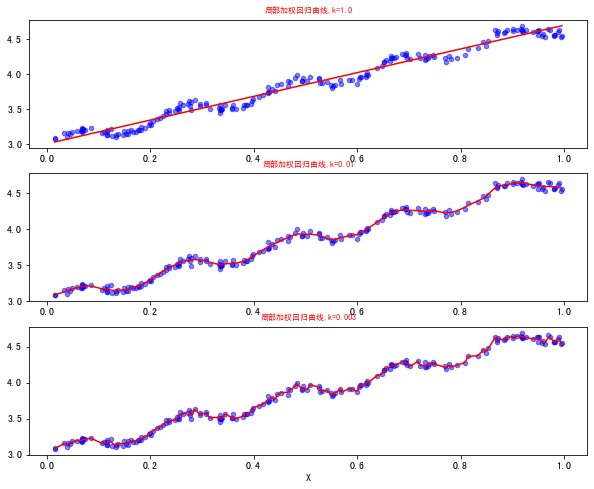

In [6]:
def plotlwlrRegression():
    """
    函数说明:绘制多条局部加权回归曲线
    Parameters:
        无
    Returns:
        无

    """
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签，黑体的 name 为 SimHei
    plt.rcParams['font.size'] = 10  # 设置字体大小
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号，跟是否显示中文没关系，你可以考虑加或不加
    xArr, yArr = loadDataSet('data/Ch08/ex0.txt')                                   #加载数据集
    yHat_1 = lwlrTest(xArr, xArr, yArr, 1.0)                            #根据局部加权线性回归计算yHat
    yHat_2 = lwlrTest(xArr, xArr, yArr, 0.01)                            #根据局部加权线性回归计算yHat
    yHat_3 = lwlrTest(xArr, xArr, yArr, 0.003)                            #根据局部加权线性回归计算yHat
    xMat = np.mat(xArr)                                                    #创建xMat矩阵
    yMat = np.mat(yArr)                                                    #创建yMat矩阵
    srtInd = xMat[:, 1].argsort(0)                                        #排序，返回索引值
    xSort = xMat[srtInd][:,0,:]
    fig, axs = plt.subplots(nrows=3, ncols=1,sharex=False, sharey=False, figsize=(10,8))                                        
    axs[0].plot(xSort[:, 1], yHat_1[srtInd], c = 'red')                        #绘制回归曲线
    axs[1].plot(xSort[:, 1], yHat_2[srtInd], c = 'red')                        #绘制回归曲线
    axs[2].plot(xSort[:, 1], yHat_3[srtInd], c = 'red')                        #绘制回归曲线
    axs[0].scatter(xMat[:,1].flatten().A[0], yMat.flatten().A[0], s = 20, c = 'blue', alpha = .5)                #绘制样本点
    axs[1].scatter(xMat[:,1].flatten().A[0], yMat.flatten().A[0], s = 20, c = 'blue', alpha = .5)                #绘制样本点
    axs[2].scatter(xMat[:,1].flatten().A[0], yMat.flatten().A[0], s = 20, c = 'blue', alpha = .5)                #绘制样本点
    #设置标题,x轴label,y轴label
    axs0_title_text = axs[0].set_title(u'局部加权回归曲线,k=1.0')
    axs1_title_text = axs[1].set_title(u'局部加权回归曲线,k=0.01')
    axs2_title_text = axs[2].set_title(u'局部加权回归曲线,k=0.003')
    plt.setp(axs0_title_text, size=8, weight='bold', color='red')  
    plt.setp(axs1_title_text, size=8, weight='bold', color='red')  
    plt.setp(axs2_title_text, size=8, weight='bold', color='red')  
    plt.xlabel('X')
    plt.show()
    
def lwlrTest(testArr, xArr, yArr, k=1.0):  
    """
    函数说明:局部加权线性回归测试
    Parameters:
        testArr - 测试数据集
        xArr - x数据集
        yArr - y数据集
        k - 高斯核的k,自定义参数
    Returns:
        ws - 回归系数
    """
    m = np.shape(testArr)[0]                                            #计算测试数据集大小
    yHat = np.zeros(m)    
    for i in range(m):                                                    #对每个样本点进行预测
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    return yHat

plotlwlrRegression()

可以看到，k = 1.0时的模型效果与最小二乘法差不多，k = 0.01时该模型可以挖出数据的潜在规律，而k = 0.003时则考虑了太多的噪声，进而导致了过拟合现象。

## 8.3 缩减系数“理解”数据

如果数据的特征比样本点还多应该怎么办？是否还可以使用线性回归和之前的方法来做预测？答案是否定的，即不能再使用前面介绍的方法。这是因为在计算$(X^TX)^{-1}$的时候会出错。 

如果特征比样本点还多（n > m），也就是说输入数据的矩阵X不是满秩矩阵。非满秩矩阵在
求逆时会出现问题。

为了解决这个问题，统计学家引入了岭回归（ridge regression）的概念，这就是本节将介绍
的第一种缩减方法。接着是lasso法，该方法效果很好但计算复杂。本节最后介绍了第二种缩减方
法，称为前向逐步回归，可以得到与lasso差不多的效果，且更容易实现。

### 8.3.1 岭回归

简单说来，岭回归就是在矩阵$X^TX$上加一个$λI$从而使得矩阵非奇异，进而能对$X^TX + λI$求逆。其中矩阵I是一个m×m的单位矩阵，对角线上元素全为1，其他元素全为0。而λ是一个用户定义的数值，后面会做介绍。

在这种情况下，回归系数的计算公式将变成
$$
 \hat{w} = (X^TX+λI)^{-1}X^Ty
$$

岭回归最先用来处理特征数多于样本数的情况，现在也用于在估计中加入偏差，从而得到更好的估计。这里通过引入λ来限制了所有w之和，通过引入该惩罚项，能够减少不重要的参数，这个技术在统计学中也叫做缩减（shrinkage）。

> 岭回归使用了单位矩阵乘以常量λ，我们观察其中的单位矩阵I，可以看到值1贯穿整个对角线，其余元素全是0。形象地，在0构成的平面上有一条1组成的“岭”，这就是岭回归中的“岭”的由来。

缩减方法可以去掉不重要的参数，因此能更好地理解数据。此外，与简单的线性回归相比，缩减法能取得更好的预测效果。 与前几章里训练其他参数所用的方法类似，这里通过预测误差最小化得到λ：数据获取之后，首先抽一部分数据用于测试，剩余的作为训练集用于训练参数w。训练完毕后在测试集上测试预测性能。通过选取不同的λ来重复上述测试过程，最终得到一个使预测误差最小的λ。

为了使用岭回归和缩减技术，首先需要对特征做标准化处理。回忆一下，第2章已经用过标准化处理技术，使每维特征具有相同的重要性（不考虑特征代表什么）。程序清单8-3中的第二个函数ridgeTest()就展示了数据标准化的过程。具体的做法是所有特征都减去各自的均值并除以方差 。

### 8.3.2 lasso

### 8.3.3 前向逐步回归


## 8.4 本章小结

当数据的样本数比特征数还少时候，矩阵$X^TX$的逆不能直接计算。即便当样本数比特征数多时，$X^TX$的逆仍有可能无法直接计算，这是因为特征有可能高度相关。这时可以考虑使用岭回归，因为当$X^TX$的逆不能计算时，它仍保证能求得回归参数。岭回归是缩减法的一种，相当于对回归系数的大小施加了限制。

另一种很好的缩减法是lasso。Lasso难以求解，但可以使用计算简便的逐步线性回归方法来求得近似结果。缩减法还可以看做是对一个模型增加偏差的同时减少方差。偏差方差折中是一个重要的概念，可以帮助我们理解现有模型并做出改进，从而得到更好的模型。

本章介绍的方法很有用。但有些时候数据间的关系可能会更加复杂，如预测值与特征之间是非线性关系，这种情况下使用线性的模型就难以拟合。下一章将介绍几种使用树结构来预测数据的方法。